# Interactive Monte Carlo Path Tracer 
## By Brandon Percin

This notebook is part of my MS Course Project in Deep Learning, "Denoising Monte Carlo Path-Traced Images using Convolutional Neural Networks." It covers the implementation of the underlying Monte Carlo Path Tracer, which itself is related to one of my earlier works, the C++ Raytracer Renderer, which I originally built as a term project during my undergraduate degree. This notebook is an extension of my learning from my graduate studies at UCD, wherin I implemented Monte Carlo Path Tracing, a randomized sub-sampling variant of ray tracing based on the concept of Monte Carlo Integration, in order to observe how deep neural networks can be used to speed up the rendering process.

**NOTE: This implementation presented in this Notebook is a Path Tracer, not a Ray Tracer. While related, the underlying tecniques employed by each rendering method is completely different. I am simply citing my original work in this notebook as it served as a major learning point in my understanding of rendering techniques and computer graphics. For additional questions, please reach out to me directly.**


Original C++ Implementation of Raytracer is available to view at the following Github repository:
https://github.com/Chiiryuu/Raytracer

The original Ray Trace Renderer was finished in October, 2019, and was created as a term project for the Colorado State University course CS 410: Introduction to Computer Graphics, with Professor J. Ross Beveridge.
The source code includes a makefile, so if you have g++ or a similar c++ compiler, run 'make' to compile the code. Conversely, if on Windows, you can import the source files into Visual Studio and compile from there.
NOTE: The source code is tested only on Ubuntu

This implementation, presented as a component of my MS course project, is based on the rendering equation and techniques introduced in the papers "The Rendering Equation" and "Monte Carlo Path Tracing," which are cited as sources [1] and [2] respectfully in my Project Report. For any questions related to the implementation of the Path Tracer component of this project, do not hesitate to reach out to me.

In [1]:
### IMPORTS

# Generally required libraries
import math
import os.path
import time
import numpy as np
import datetime
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import matplotlib.pyplot as plt

# For importing images
import cv2

# PIL to convert PPM to PNG
from PIL import Image
# Import ipython's image to render image in notebook
from IPython.display import Image as jupyterImage

# Monte Carlo Simulation randomness
import random

In [2]:
### HELPER FUNCTIONS ###

# Restricts input to 0 <= input <= 1
def clamp(val, minimum = 0, maximum = 1):
    return min(max(val, minimum), maximum)

# Converts brightness float to color depth integer
# Also applies gamma correction to brighten image (or darken optionally)
def floatToPixelVal(value, gammaCorrection = 2.2, colorDepth = 255):
    correction = clamp(value) ** (1/gammaCorrection)
    return clamp(round(correction * colorDepth), 0, colorDepth)
    
    
# Useful vector functions
# work as expected; returns either magnitude or normalized vector
def normalized(vector):
    magnitude = np.linalg.norm(vector)
    if (magnitude <= 0):
        return np.array([0,1,0])
    return  vector / magnitude

def magnitude(vector):
    return np.linalg.norm(vector)




### IMAGE OUTPUT FUNCTIONS ###

# Output pixel array to PPM  V6file
# Not easily viewable in Windows, thus we use PIL to convert
def writePPM(fileName, width, height, pixelArray, gammaCorrection = 2.2 ,colorDepth = 255):
    with open(fileName, 'w') as imageFile:
        # Required for PPM: identifier, x/y size, color depth
        imageFile.write('P6\n')
        imageFile.write('{} {}\n'.format(width, height))
        imageFile.write('{}\n'.format(colorDepth))
        # We close the file, as we need to re-open it in binary mode
        imageFile.close()
    # Open in binary mode for appending    
    with open(fileName, 'ab') as imageFile:
        # Loop to write pixel array to file
        for i in range(len(pixelArray)):
            # Write pixel to file
            pixel = pixelArray[i]
            
            # Reorder pixels (PPM P6 has a strange ordering)
            # This ensures pixelarray is correctly written as RGB values
            # R,G,B -> G, B, R
            # This also re-scales the pixel values from [0,1] to [0,colorDepth]
            pixel = [floatToPixelVal(pixel[1], gammaCorrection, colorDepth),
                    floatToPixelVal(pixel[2], gammaCorrection, colorDepth),
                    floatToPixelVal(pixel[0], gammaCorrection, colorDepth)]
            
            # We convert each number to a bytes-like object
            # This is required by PPM v6
            pixel = (pixel[0].to_bytes(1, 'little'), pixel[1].to_bytes(1, 'little'), pixel[2].to_bytes(1, 'little'))
            # Write the pixel bytes to file
            imageFile.write(pixel[0])
            imageFile.write(pixel[1])
            imageFile.write(pixel[2])
        # Finish with extra newline
        imageFile.close()

# Use PIL to convert ppm file to png (to easily see on windows)
def writePNG(fileName, width, height, pixelArray,  gammaCorrection = 2.2 ,colorDepth = 255):
    ppmFile = fileName+'.ppm'
    writePPM(ppmFile, width, height, pixelArray, gammaCorrection, colorDepth)
    
    # Halt until ppm file updated in local file system
    while not os.path.exists(ppmFile):
        time.sleep(1)
    
    im = Image.open(ppmFile)
    im.save(fileName)
       

# Output pixel array to PPM V3 (completely ASCII)
# Not used because some operating systems do not recognize it
def writePPMV3(fileName, width, height, pixelArray, gammaCorrection = 2.2 ,colorDepth = 255):
    with open(fileName, 'w') as imageFile:
        # Required for PPM: identifier, x/y size, color depth
        imageFile.write('P3\n')
        imageFile.write('{} {}\n'.format(width, height))
        imageFile.write('{}\n'.format(colorDepth))
        
        curCol = 0
        
        # Loop to write pixel array to file
        for i in range(len(pixelArray)):
            # Write pixel to file
            pixel = pixelArray[i]
            
            if (curCol >= width):
                imageFile.write('\n')
                curCol = 0
            
            # Clamp channel colors and apply gamma correction
            pixel = [floatToPixelVal(pixel[0], gammaCorrection, colorDepth),
                    floatToPixelVal(pixel[1], gammaCorrection, colorDepth),
                    floatToPixelVal(pixel[2], gammaCorrection, colorDepth)]
            
            # We convert each number to a bytes-like object
            # This is required by PPM v6
            # Write the pixel bytes to file
            imageFile.write('{} {} {}\t'.format(pixel[0],pixel[1],pixel[2]))
            
            curCol += 1
        # Finish with extra newline
        imageFile.close()

# Use PIL to convert ppm file to png (to easily see on windows)
def writePNG(fileName, width, height, pixelArray, gammaCorrection = 2.2 ,colorDepth = 255):
    ppmFile = fileName+'.ppm'
    writePPM(ppmFile, width, height, pixelArray, gammaCorrection, colorDepth)
    
    # Halt until ppm file updated in local file system
    while not os.path.exists(ppmFile):
        time.sleep(1)
    
    im = Image.open(ppmFile)
    im.save(fileName)





### OBJECT DEFINITIONS ### 


# Definition for object material - attribute of object
class Material:
    def __init__(self, ambient=[1.0,1.0,1.0], diffuse=[1.0,1.0,1.0], specular=[1.0,1.0,1.0], attenuation=[1.0,1.0,1.0], Ni = 1.0):
        self.ambient = np.array(ambient)
        self.diffuse = np.array(diffuse)
        self.specular = np.array(specular)
        self.attenuation = np.array(attenuation)
        self.Ni = Ni

# Definition for sphere object        
class Sphere:
    def __init__(self, position, radius, ambient, diffuse, specular, attenuation=[1.0,1.0,1.0], Ni = 1.0):
        self.origin =np.array(position)
        self.radius = radius
        self.material = Material(ambient,diffuse, specular, attenuation, Ni)

# Definition for camera object
class Camera:
    def __init__(self, position, lookVector, upVector, d, bounds, resolution):
        self.position = np.array(position)
        self.lookVector = np.array(lookVector)
        self.upVector = np.array(upVector)
        self.d = d
        self.bounds = bounds
        self.resolution = resolution
        
        # Calculate useful vectors
        self.w = normalized(self.position - self.lookVector)
        self.u = np.cross(self.upVector, self.w)
        self.v = np.cross(self.w, self.u)

# Definition for Light object
# If radius = 0, point light. Else, spherical emitter
class Light:
    def __init__(self, position, color, radius = 0):
        self.position = np.array(position)
        self.color = np.array(color)
        self.radius = radius
        
# Definition for Scene object
# Includes built-in functions
class Scene:
    def __init__(self, camera, ambientColor = [0.2, 0.2, 0.2 ], recursionDepth = 0, globalAttenuation = [0.8,0.8,0.8]):
        self.camera = camera
        self.ambient = np.array(ambientColor)
        self.lights = []
        self.spheres = []
        self.objects = []
        self.recursionLevel = recursionDepth
        self.globalAttenuation = np.array(globalAttenuation)
        
    def setRecursion(self, level):
        self.recursionLevel = level
    
    def addLight(self, light):
        self.lights.append(light)
    
    def addSphere(self, sphere):
        self.spheres.append(sphere)
        
    def setResolution(self, resolution):
        self.camera.resolution = resolution
        
    # Save a scene to a readable scene file 
    # Useful for saving randomly generated scenes
    def toFile(self, fileName, prefixComments = ''):
        with open(fileName, 'w') as sceneFile:
            
            if (len(prefixComments) > 0):
                for line in prefixComments.splitlines():
                     sceneFile.write('# {}\n'.format(line))
            
            
            sceneFile.write('recursionlevel {}\n'.format(self.recursionLevel))
            
            sceneFile.write('eye {} {} {}\n'.format(*self.camera.position))
            sceneFile.write('look {} {} {}\n'.format(*self.camera.lookVector))
            sceneFile.write('up {} {} {}\n'.format(*self.camera.upVector))
            sceneFile.write('d {}\n'.format(self.camera.d))
            sceneFile.write('bounds {} {} {} {}\n'.format(*self.camera.bounds))
            sceneFile.write('resolution {} {}\n'.format(*self.camera.resolution))
                            
            sceneFile.write('ambient {} {} {}\n'.format(*self.ambient))
            
            for light in self.lights:
                sceneFile.write('light {} {} {} 0 {} {} {} {}\n'.format(*light.position, *light.color, light.radius))
                
            for sphere in self.spheres:
                sceneFile.write('sphere {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format(*sphere.origin, sphere.radius, *sphere.material.ambient, *sphere.material.diffuse, *sphere.material.specular, *sphere.material.attenuation, sphere.material.Ni))
            
            sceneFile.close()

In [3]:
# This cell creates pixel arrays for testing

# Red, green, and blue gradient images respectfully

size = 10000


rArr = [[0,0,0]]*size
for i in range(size):
    testVal = (i/size)
    rArr[i] = [testVal,0,0]
    
gArr = [[0,0,0]]*size
for i in range(size):
    testVal = (i/size)
    gArr[i] = [0,testVal,0]
    
bArr = [[0,0,0]]*size
for i in range(size):
    testVal = (i/size)
    bArr[i] = [0,0,testVal]

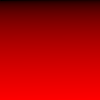

In [4]:
# Render the Red image
writePNG("images/r.png", 100, 100, rArr)
jupyterImage(filename='images/r.png') 

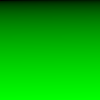

In [5]:
# Render the Green Image
writePNG("images/g.png",100,100,gArr)
jupyterImage(filename='images/g.png') 

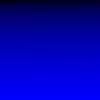

In [6]:
# Render the Blue Image
writePNG("images/b.png",100,100,bArr)
jupyterImage(filename='images/b.png') 

In [7]:
# Create a striped image with a combination of colors

stripeArr = [[0,0,0]]*10000
for i in range(size):
    
    fade = (i/size)
    
    row = i%100
    if row < 33:
        stripeArr[i] = [fade,fade,0]
    elif row < 66:
        stripeArr[i] = [0,fade,fade]
    else:
        stripeArr[i] = [fade,0,fade]

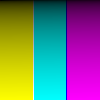

In [8]:
# Render above image
writePNG("images/s.png",100,100,stripeArr)
jupyterImage(filename='images/s.png') 

In [9]:
# Constant to determine whether sphere reflection/refraction should occur at incident angle
minT = 0.00001
# Since recursion happens probabalistically, we set a hard limit.
absoluteMaxRecursionDepth = 10

# Project random float in range [0,1] into defined  range [min, max]
def randomFloatInRange(minVal, maxVal):
    return ( random.random() * (maxVal - minVal) ) + minVal

# Return random vector 3 of color
def getRandomColor():
    return [random.random(), random.random(), random.random()]

# Generate scene within viewing frustum of default camera
def makeRandomizedScene():
    # Standardize viewing frustum pointing towards origin [0,0,0]
    camera = Camera([-100, 5.2, 5.2], [0.01, 0.01, 0.01], [0,1,0.01], -10, [-1,1,-1,1], [100,100])
    
    # Create scene from given camera
    scene = Scene(camera)
    
    # Simulate 2 recursive reflections/refractions per hit
    scene.setRecursion(2)
    
    # Generate between 4 and 10 spheres (can overlap)
    numSpheres = random.randrange(4,10)
    
    for i in range(numSpheres):
        
        sphereColor = getRandomColor()
        
        radius = randomFloatInRange(0.5, 4)
        
        position = [randomFloatInRange(-10,10), randomFloatInRange(-10,10), randomFloatInRange(-10,10)]
        
        attenuation = random.random()
        attenuation = [attenuation, attenuation, attenuation]
        
        refractiveIndex = randomFloatInRange(0.01,2)
        
        sphere = Sphere( position, radius, sphereColor, sphereColor, sphereColor, attenuation, refractiveIndex)
        
        scene.addSphere(sphere)
        
    numLights = random.randrange(1,5)
    
    for i in range(numLights):
        position = [randomFloatInRange(-50,50), randomFloatInRange(-50,50), randomFloatInRange(-50,50)]
        color = getRandomColor()
        light = Light(position, color)
        scene.addLight(light)
        
    return scene


# Method to parse Scene text file as in initial C++ implementation
# Completely optional, and scenes can be built in jupyter cells as well.
def readSceneFile(sceneFile):
    eye = [0,0,0]
    look = [0,0,0]
    up = [0,1,0]
    d = -10
    recursionLevel = 0
    bounds = [-1, 1, -1, 1]
    resolution = [100,100]
    ambient = np.array([0.2,0.2,0.2])
    lights = []
    spheres = []
    models = []
    
    sceneFile = open(sceneFile, 'r')
    for line in sceneFile:
        line = line.strip()
        # Skip comment lines
        if ('#' in line):
            continue
            
        elif 'recursionlevel ' in line:
            recursionLevel = int(line[15:])
            
        elif 'eye ' in line:
            eye = [float(x) for x in line[4:].split(' ')]
        
        elif 'look ' in line:
            look = [float(x) for x in line[5:].split(' ')]   
            
        elif 'up ' in line:
            up = [float(x) for x in line[3:].split(' ')]
            
        elif 'd ' in line:
            d = float(line[2:])
            
        elif 'bounds ' in line:
            bounds = [float(x) for x in line[7:].split(' ')]
            
        elif 'res ' in line:
            res = [int(x) for x in line[4:].split(' ')]
            
        elif 'ambient ' in line:
            ambient = [float(x) for x in line[8:].split(' ')]
            
        elif 'light ' in line:
            newLight = [float(x) for x in line[6:].split(' ')]
            lightPos = [ newLight[0], newLight[1], newLight[2] ]
            lightW = newLight[3]
            lightColor = [ newLight[4], newLight[5], newLight[6]]
            lightRadius = 0
            if (len(newLight) > 7):
                        lightRadius = newLight[7]
            lights.append(Light(lightPos,lightColor, lightRadius))
        
        elif 'sphere ' in line:
            refractiveIndex = 1.0
            newSphere = [float(x) for x in line[7:].split(' ')]
            pos = [ newSphere[0], newSphere[1], newSphere[2] ]
            r = newSphere[3]
            ambient = [ newSphere[4], newSphere[5], newSphere[6]]
            diffuse = ambient = [ newSphere[7], newSphere[8], newSphere[9]]
            specular = [ newSphere[10], newSphere[11], newSphere[12]]
            attenuation = [ newSphere[13], newSphere[14], newSphere[15]]
            if (len(newSphere) == 17):
                refractiveIndex = newSphere[16]
            spheres.append(Sphere(pos,r,ambient,diffuse,specular,attenuation, refractiveIndex))           
    
    camera = Camera(eye, look, up, d, bounds, resolution)
    
    scene = Scene(camera, ambient, recursionLevel)
    
    for light in lights:
        scene.addLight(light)
    
    for sphere in spheres:
        scene.addSphere(sphere)
    
    return scene
            
        

# Check if ray intercects any spheres (and return closest one)
def checkRaySphereCollision(scene, Lv, Dv, minDistance, maxDistance = 9999999999):
    # Quick exit if no spheres in scene
    if len(scene.spheres) == 0:
        return (None, None)
    
    hitSphere = None
    
    
    spheres = scene.spheres
    for sphere in scene.spheres:
        
        # Calculate intersection disc
        rayToSphere = sphere.origin - Lv
        v = np.dot(rayToSphere, Dv)
        cc = np.dot(rayToSphere, rayToSphere)
        disc = (sphere.radius**2) - (cc - (v**2))
        
        # If positive, we have a hit
        if (disc > 0):
            d = disc**0.5
            distance =  v - d
            
            # Rays intersect sphere surface at 2 points, find which is closer to camera
            if (distance > minT and distance < minDistance and distance < maxDistance):
                minDistance = distance
                hitSphere = sphere
            else:
                distance = v + d
                if (distance > minT and distance < minDistance and distance < maxDistance):
                    minDistance = distance
                    hitSphere = sphere
    return (hitSphere, minDistance)
            

# This is a quick-exit version of the previous function
def isPathBlocked(scene, Lv, Dv, maxDistance = 9999999999999 ):
    for sphere in scene.spheres:
        # Calculate intersection disc
        rayToSphere = sphere.origin - Lv
        v = np.dot(rayToSphere, Dv)
        cc = np.dot(rayToSphere, rayToSphere)
        disc = (sphere.radius**2) - (cc - (v**2))
        
        # If positive, we have a hit
        if (disc > 0):
            d = disc**0.5
            distance =  v - d
            
            # Rays intersect sphere surface at 2 points, find which is closer to camera
            if (distance > minT and distance < maxDistance):
                return True
            else:
                distance = v + d
                if (distance > minT and distance < maxDistance):
                    return True
    return False

# Calculate angle through surface where ray refracts
def refractRay(W, N, etaIn, etaOut):
    etaRatio = etaIn / etaOut
    a = 0 - etaRatio
    WN = np.dot(W,N)
    radSq = ( (etaRatio**2) * ((WN**2)-1) ) + 1
    if (radSq < 0):
        return np.array([0,0,0])
    b = (etaRatio * WN) - (radSq**0.5)
    T = (W * a) + (N * b)
    return T

# Quickly calculate both entrance and exit to sphere
def refractRayThroughSphere(Lv, Dv, sphere, W, pt, N, etaIn, etaOut):
    T1 = refractRay(W, N, etaOut, etaIn)
    if (magnitude(T1) < 0.000):
        return False, None, None
    
    exit = (pt + (T1 * 2.0 * ( np.dot(sphere.origin - pt, T1) ) ) )
    Nin = normalized(sphere.origin - exit)
    T2 = refractRay( (-1 * T1), Nin, etaIn, etaOut )
    # Ray in form origin, direction
    return True, exit, T2

# The underlying ray tracer (monte carlo happens before this)
def getRayCollisionColor(scene, Lv, Dv, totalColor, totalAttenuation, maxRecursionLevel, recursionLevel, etaOut = 1):
    minDistance = 999999
    hitIndex = faceIndex = -1
    hitObject = refract = False
    reflect = True
    alpha = 1
    
    
    hitPoint = sphereCenter = N = None
    
    etaIn = B = Y = 0
    
    hitSphere, sphereDistance = checkRaySphereCollision(scene, Lv, Dv, minDistance)
    
    if hitSphere != None:
        hitObject = True
        minDistance = sphereDistance
    
    
    # If we hit nothing, just return
    if (not hitObject):
        if (recursionLevel == 0):
            return ( np.array([0,0,0]), minDistance )
        return np.array([0,0,0])
    
    # If we recursed too deeply, stop
    if (recursionLevel > absoluteMaxRecursionDepth):
        if (recursionLevel == 0):
            return ( np.array([0,0,0]), minDistance )
        return np.array([0,0,0])
    
    hitPoint = Lv + (Dv * minDistance)
    
    color = scene.ambient * hitSphere.material.ambient
    
    diffuse = hitSphere.material.diffuse
    specular = hitSphere.material.specular
    attenuation = hitSphere.material.attenuation
    
    
    terminationProbability = 0.2
    
    
    
    if (recursionLevel > maxRecursionLevel or random.random() < terminationProbability):
        if (random.random() < terminationProbability):
            if (recursionLevel == 0):
                return ( 2 * color * diffuse, minDistance )
            return 2 * color * diffuse
        color = color * (1 / terminationProbability)
    
    
    if (magnitude(attenuation) < minT):
        reflect = False
        
    N = (hitPoint - hitSphere.origin)
    
    if (np.dot(N, Dv) > 0):
        N = -1*N
    N = normalized(N)
    
    etaIn = hitSphere.material.Ni
    
    alpha = 16
    
    if (etaIn > 0.000001):
        refract = True
    
    
    # Find lights illuminated by shape
    for light in scene.lights:
        toL = light.position - hitPoint
        distanceToLight = magnitude(toL)
        toL = normalized(toL)
        dotProduct = np.dot(N, toL)
        
        # Calculate lighting
        if (dotProduct > 0.0 and not isPathBlocked(scene, hitPoint, toL, distanceToLight)):
            color = color + ( dotProduct * ( diffuse * light.color ))  
            # Calculate Specular Highlight
            toC = normalized(Lv - hitPoint)
            spR = normalized(((2*dotProduct)*N)-toL)
            CdR = np.dot(toC,spR)
            if (CdR > 0.0):
                color = color + (( specular * light.color)*( CdR**alpha ))
            
    # Update Color with hit object / lighting      
    totalColor = totalColor + (totalAttenuation * color)
    
    # Calculate Reflections
    
    # If material is not reflective or refractive, perform randomized diffuse reflection
    # This is a core concept of Monte Carlo path reacing
    if not (reflect or refract):
        phi = random.random() * math.pi * 2
        z = random.random()
        zRoot = math.sqrt(z)
        zRootPrime = math.sqrt(1 - z)
        
        u = np.array([1.0 ,0.0 ,0.0])
        
        # Ensure u is orthagonal to normal
        if (N[0] > 0.1):
            u = np.array([0.0 ,1.0 ,0.0])
            
        v = np.cross(N, u)
        
        # Calculate random reflected direction in hemisphere around surface normal
        refDir = normalized(zRoot * math.cos(phi)* u) + (math.sin(phi) * zRoot * v) + (zRootPrime * N)
        
        totalColor +=  getRayCollisionColor(scene, hitPoint, refDir, totalColor, (attenuation*totalAttenuation*scene.globalAttenuation), maxRecursionLevel, recursionLevel + 1, etaOut)
        
    
    else: # Otherwise, perform reflecting or refracting like normal
        Uinv = -1*Dv
        # Reflections are simply double the angle of incidence
        
        if (reflect):
            R = (N * (2*np.dot(N,Uinv)))-Uinv

            if (magnitude(R) > 0):
                R = normalized(R)
                if (np.dot(N,R) > 0.001):
                    totalColor += getRayCollisionColor(scene, hitPoint, R, totalColor, (attenuation*totalAttenuation*scene.globalAttenuation), maxRecursionLevel, recursionLevel + 1, etaOut)
        if (refract):
            validRefraction, refractLv, refractDv = refractRayThroughSphere(Lv, Dv, hitSphere, Uinv, hitPoint, N, etaIn, etaOut)
            if validRefraction:
                refractVal = np.array([1,1,1]) - attenuation
                totalColor +=   getRayCollisionColor(scene, refractLv, refractDv, totalColor, (totalAttenuation * refractVal*scene.globalAttenuation), maxRecursionLevel, recursionLevel + 1, etaOut)
    
    # If this is an initial ray, record depth
    if recursionLevel == 0:
        return ( (2 * totalColor *scene.globalAttenuation) , minDistance )
    return 2 * totalColor *scene.globalAttenuation
    

# Handles the Monte Carlo operation, calls above method
def calculateColorFromRay(scene, colorIn, rayOrigin, rayDirection, recursionLevel):
    #return np.absolute(rayDirection * np.array([10,10,1]))
    
    color = np.array([0,0,0])

    colorIn, depth =  getRayCollisionColor(scene, rayOrigin, rayDirection, color, np.array([1,1,1]), recursionLevel, 0)
    
    # Pass color and depth if depth is requested
    colorIn = np.array([colorIn[0], colorIn[1], colorIn[2], depth])
    
    return colorIn
    


# Renders scene to file
# Additionally casts 4 rays per sample in order to smooth rough edges (at ~= 4x runtime)
def traceWithSmoothing(scene, recursionLevel = -1, samplesPerPixel = 1):
    # If recursion level not specified, use value in scene object
    if (recursionLevel != -1):
        scene.recursionLevel  = recursionLevel
    
    width, height = scene.camera.resolution
    pixelArray = []
    
    left, right, bottom, top = scene.camera.bounds
    
    eye = scene.camera.position
    w = scene.camera.w
    u = scene.camera.u
    v = scene.camera.v
    
    nearClippingPlane = scene.camera.d
    
    numPixels = width * height
    
    pixelArray = [np.zeros(3)]*numPixels
    
    for t in range(numPixels):
        i = t // width
        j = t % width
        
        depth = 0
        
        pixelColor = np.array([0,0,0])
        
        fractionPerPixel = 1 / samplesPerPixel
        
        # Smooth final image by splitting each pixel into 4 sub-components
        # Makes image look much nicer (not same as monte carlo samples per pixel)
        for subx, suby in [(0,0),(1,0),(0,1),(1,1)]:
        
            # Iterate over Monte-Carlo sub-samples (randomized reflections, etc)
            for sample in range(samplesPerPixel):
            
                dx = dy = 0
            
                jitterX = 2 * random.random()
                jitterY = 2 * random.random()
            
                if (jitterX < 1):
                    dx = (jitterX ** 0.5) -1
                else:
                    dx = 1 - ((2 - jitterX) ** 0.5)
                
                
                if (jitterY < 1):
                    dy = (jitterY ** 0.5) - 1
                else:
                    dy = 1 - ((2 - jitterY) ** 0.5)
                   
            
                px = (((subx+0.5+dx)/2) + j)/(width-1)*(right-left)+left
                py = (((suby+0.5+dx)/2) + i)/(height-1)*(bottom-top)+top
        
                rayOrigin = (eye + ( w*nearClippingPlane )) + ((u*px + v*py) )
        
                rayDirection = normalized(rayOrigin - eye)
            
                subPixelColor = calculateColorFromRay(scene, np.array([0,0,0]), rayOrigin, rayDirection, scene.recursionLevel)
                
                depth = depth + ( 0.25 * fractionPerPixel * subPixelColor[3])
                
                subPixelColor = np.resize(subPixelColor, 3)
        
                pixelColor = pixelColor +  ( 0.25 * 0.25 * fractionPerPixel * subPixelColor)
            
            
            
    
            # Correct by # smoothing samples (4 per pixel)
            pixelArray[t] = [*(pixelColor), depth]
    
    return pixelArray
    
    
    
    
# Primary path tracing function
# Renders scene to file (and optionally calls above function if sub-pixel smoothing is requested)
# Calculates each ray coming from camera, calls "calculateColorFromRay" on each
# Basis for above function; they are identical aside from the per-pixel smoothing
def trace(scene, recursionLevel = -1, samplesPerPixel = 1, performSmoothing = False):
    
    # If called with smoothing, call modified smoothing method
    if (performSmoothing):
        return traceWithSmoothing(scene, recursionLevel, samplesPerPixel)
          
        
    # If recursion level not specified, use value in scene object
    if (recursionLevel != -1):
        scene.recursionLevel  = recursionLevel
    
    width, height = scene.camera.resolution
    pixelArray = []
    
    left, right, bottom, top = scene.camera.bounds
    
    eye = scene.camera.position
    w = scene.camera.w
    u = scene.camera.u
    v = scene.camera.v
    
    nearClippingPlane = scene.camera.d
    
    numPixels = width * height
    
    pixelArray = [np.zeros(3)]*numPixels
    
    for t in range(numPixels):
        i = t // width
        j = t % width
        
        depth = 0
        
        pixelColor = np.array([0,0,0])
        
        fractionPerPixel = 1 / samplesPerPixel
        
        # Iterate over Monte-Carlo sub-samples (randomized reflections, etc)
        for sample in range(samplesPerPixel):
            px = (j)/(width-1)*(right-left)+left
            py = (i)/(height-1)*(bottom-top)+top
        
            rayOrigin = (eye + ( w*nearClippingPlane )) + ((u*px + v*py) )
        
            rayDirection = normalized(rayOrigin - eye)
            
            subPixelColor = calculateColorFromRay(scene, np.array([0,0,0]), rayOrigin, rayDirection, scene.recursionLevel)
            
            # Depth is implemented as a 4th channel
            depth = depth + (fractionPerPixel * subPixelColor[3])
            
            subPixelColor = np.resize(subPixelColor, 3)
        
            pixelColor = pixelColor +  ( 0.25 * fractionPerPixel * subPixelColor)
    
        pixelArray[t] = pixelColor
        pixelArray[t] = [*(pixelColor), depth]
    
    return pixelArray

# Actually generate training samples in a given directory
# Includes txt file for corresponding depths, as well as a scene file for each generated scene
def generateTrainSamples(directory, count, lowerRecursionLimit = 3, xSamples = 1, ySamples = 10, performSmoothing = False):
    
    # We will store rendering times for later analysis
    xRenderTimes = np.zeros(count)
    yRenderTimes = np.zeros(count)
    
    for i in range(count):
        # Generate scene for training example
        scene = makeRandomizedScene()
        # Standardize set with 100,100 resolution
        # Not 200x200 like examples because this is too slow to render
        scene.setResolution([100,100])
        
        # Render x_Image and record time
        start = time.time()
        xImage = trace(scene, lowerRecursionLimit, xSamples, performSmoothing)
        xTime = time.time() - start
        
        # Filter out exclusively returned depth
        depthX = [x[3] for x in xImage]
        # Save depth to file for use in NN
        np.savetxt('{}/{}_depth.csv'.format(directory,i), depthX, delimiter=',')
        
        # Save x_img to file
        width, height = scene.camera.resolution
        writePNG('{}/{}_input.png'.format(directory,i), width, height, xImage, 1.0, 255)
        
        # Render y_image and record time
        start = time.time()
        yImage = trace(scene, lowerRecursionLimit, ySamples, performSmoothing)
        yTime = time.time() - start
        
        # Save y_img to file
        writePNG('{}/{}_expected-out.png'.format(directory,i), width, height, yImage, 1.0, 255)
        
        # Write comment for scene file, for later lookup
        sceneComment = 'Test Sample {}\nx-samples: {}\ny-samples: {}\nused smoothing: {}\nx time: {}\ny time: {}'.format(i, xSamples, ySamples, performSmoothing, xTime, yTime)        
        
        # Save scene to file for later use
        scene.toFile('{}/{}-scene.txt'.format(directory,i), sceneComment)
        
        # Update rendering times in our list
        xRenderTimes[i] = xTime
        yRenderTimes[i] = yTime
    
    # Save rendering times to file for later use
    np.savetxt('{}/xRenderTimes.csv'.format(directory), xRenderTimes, delimiter=',')
    np.savetxt('{}/yRenderTimes.csv'.format(directory), yRenderTimes, delimiter=',')
    
    print("Training Sample Generation Complete\nAvg vs Total X-Rendering Time: {}s / {}s\nAvg vs Total Y-Rendering Time: {}s / {}s".format(np.average(xRenderTimes), np.sum(xRenderTimes), np.average(yRenderTimes), np.sum(yRenderTimes)   ))
    
        
            


# Main function for if code is exported to .py file
# Not executable in a notebook
def main():
    start = time.time()

In [10]:
# Example of building a scene in a cell

# Begin by creating camera (eye, look, up, near clipping plane, bounds, resolution)
camera = Camera([25, 25, 60], [25, 25, 10], [0,1,0], -10, [-1,1,-1,1], [100,100])

# Create scene from given camera
scene = Scene(camera)

# Create and add a sphere to scene
# position, radius, ambient, diffuse, specular, attenuation, eta/Ni (optional, refractive Index)
sphere = Sphere([25,25,10], 4, [0.2, 0.2, 0.2], [0.7, 0.7, 0.7], [0.5, 0.5, 0.5])
scene.addSphere(sphere)

# Create and add lights to scene
# position, color
light1 = Light([5, 32, 30], [0.5, 1, 0.5])
light2 = Light([45, 32, 30], [1, 0.5, 0.5])
scene.addLight(light1)
scene.addLight(light2)


# The resolution can be redefined at will
scene.setResolution([200,200])

In [11]:
%%time
# Cornell Box with fixed sampling

scene = readSceneFile('scenes/monteCarloSpheres.txt')
scene.setResolution([100,100])
a = trace(scene, recursionLevel = 1, samplesPerPixel = 1, performSmoothing = True)

CPU times: total: 2min
Wall time: 2min


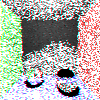

In [12]:
width, height = scene.camera.resolution
writePNG("images/cornell-fixed.png",width, height,a, 1)
jupyterImage(filename='images/cornell-fixed.png', width = 100) 

In [30]:
%%time

# Fixed sampling for spiral rainbow

scene = readSceneFile('scenes/rainbowSpiral.txt')
scene.setResolution([200,200])
c = trace(scene, recursionLevel = 1, samplesPerPixel = 1, performSmoothing = True)

CPU times: total: 14min 17s
Wall time: 14min 17s


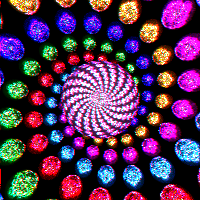

In [33]:
width, height = scene.camera.resolution
writePNG("images/rainbow-spiral.png",width, height,c, 1)
jupyterImage(filename='images/rainbow-spiral.png', width = 100) 

In [ ]:
# Set up randomized scene, 200x200 px
scene = makeRandomizedScene()
scene.setResolution([200,200])

In [203]:
# Save randomly generated scene to file

scene.toFile('scenes/random-scene-example.txt', 'Scene generated for notebook example')

CPU times: total: 6.92 s
Wall time: 6.91 s


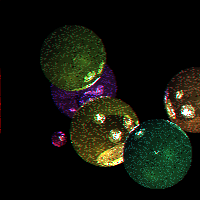

In [220]:
%%time

## One Sample, no sub-smoothing


a1 = trace(scene,3, 1, False)

width, height = scene.camera.resolution

writePNG("images/a1.png",width, height,a1, 1)

jupyterImage(filename='images/a1.png', width = 200) 

CPU times: total: 26.5 s
Wall time: 26.5 s


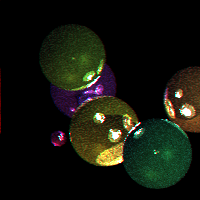

In [221]:
%%time

## One Sample, with sub-pixel smoothing


a2 = trace(scene,3, 1, True)

width, height = scene.camera.resolution

writePNG("images/a2.png",width, height,a2, 1)

jupyterImage(filename='images/a2.png', width = 200) 

CPU times: total: 31.3 s
Wall time: 31.3 s


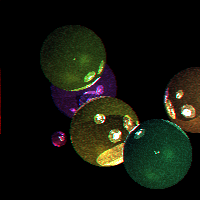

In [222]:
%%time

## 5 samples, no sub-smoothing


b1 = trace(scene,3, 5, False)

width, height = scene.camera.resolution

writePNG("images/b1.png",width, height,b1, 1)

jupyterImage(filename='images/b1.png', width = 200) 

CPU times: total: 2min 5s
Wall time: 2min 5s


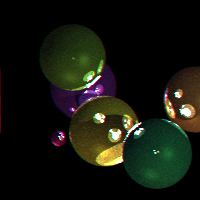

In [223]:
%%time

## 5 samples, with smoothing

b2 = trace(scene,3, 5, True)

width, height = scene.camera.resolution

writePNG("images/b2.png",width, height,b2, 1)

jupyterImage(filename='images/b2.png', width = 200) 

CPU times: total: 1min 2s
Wall time: 1min 2s


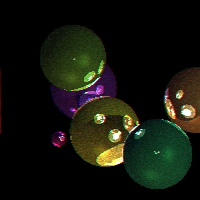

In [224]:
%%time

## 10 samples, no sub-smoothing


c1 = trace(scene,3, 10, False)

width, height = scene.camera.resolution

writePNG("images/c1.png",width, height,c1, 1)

jupyterImage(filename='images/c1.png', width = 200) 

CPU times: total: 4min 12s
Wall time: 4min 12s


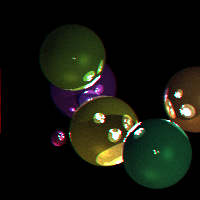

In [225]:
%%time

## 10 samples, with smoothing


c2 = trace(scene,3, 10, True)

width, height = scene.camera.resolution

writePNG("images/c2.png",width, height,c2, 1)

jupyterImage(filename='images/c2.png', width = 200) 

CPU times: total: 2min 33s
Wall time: 2min 33s


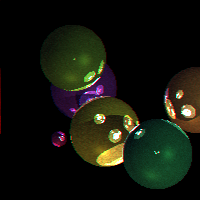

In [226]:
%%time

## 25 samples, no sub-smoothing


d1 = trace(scene,3, 25, False)

width, height = scene.camera.resolution

writePNG("images/d1.png",width, height,d1, 1)

jupyterImage(filename='images/d1.png', width = 200) 

CPU times: total: 10min 27s
Wall time: 10min 27s


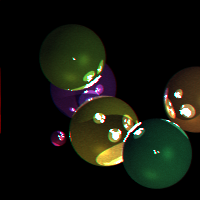

In [227]:
%%time

## 25 samples, with smoothing


d2 = trace(scene,3, 25, True)

width, height = scene.camera.resolution

writePNG("images/d2.png",width, height,d2, 1)

jupyterImage(filename='images/d2.png', width = 200) 

CPU times: total: 5min 56s
Wall time: 5min 58s


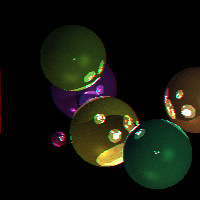

In [231]:
%%time

## 50 samples, no smoothing


e1 = trace(scene,3, 50, False)

width, height = scene.camera.resolution

writePNG("images/e1.png",width, height,e1, 1)

jupyterImage(filename='images/e1.png', width = 200) 

CPU times: total: 20min 51s
Wall time: 20min 51s


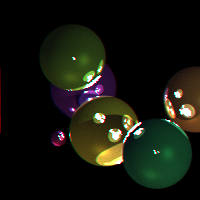

In [229]:
%%time

## 50 samples, with smoothing


e2 = trace(scene,3, 50, True)

width, height = scene.camera.resolution

writePNG("images/e2.png",width, height,e2, 1)

jupyterImage(filename='images/e2.png', width = 200) 

In [ ]:
%%time

# Generate 1000 example training images and accompanying data
# input to NN will be single sample renderings with smoothing
# ground truth will be same scene with 50 samples and smoothing

# Note that since this method takes so much time to generate 1000 samples, this was done in a .py script instead.

# generateTrainSamples('trainingSamples', 1000, lowerRecursionLimit = 3, xSamples = 1, ySamples = 50, performSmoothing = True)

In [44]:


# Tensor-based Peak Signal-to-Noise Ratio (PSNR)
# Calculates, on log scale, amount of noise in predicted image given a ground truth image
def TF_PSNR( y_true , y_pred ):

    psnr = tf.multiply(tf.constant(20, dtype=tf.float32),
        tf.math.divide(
            tf.math.log(
                tf.math.divide(
    
                    tf.math.reduce_max(y_true, axis = [1,2,3]),
                    tf.math.sqrt(
                        tf.math.reduce_mean (
                            tf.math.squared_difference(tf.cast(y_true,tf.float32) ,tf.cast(y_pred,tf.float32)) 
                        , axis = [1,2,3])
                    )
                )
            )
        , tf.math.log(tf.constant(10, dtype=tf.float32)) )
    )
    
    
    return psnr

In [12]:
# Helper function to load training data, used in train-modular notebook


def loadTestTrainDataset(count, directory = 'trainingSamples'):
    
    # Note the difference in size; y doesn't have depth channel
    x_set = np.zeros( shape = (count,100,100,4),dtype=np.float32)
    y_set = np.zeros( shape = (count,100,100,3),dtype=np.float32)
    
    for i in range(count):
        
        # Load x
        
        # Generate file paths formulaically
        imagePath = 'trainingSamples/{}_input.png'.format(i)
        depthPath = 'trainingSamples/{}_depth.csv'.format(i)
        
        # Load in depth values
        depth = np.genfromtxt(depthPath, delimiter=',').reshape(100,100,1)
        
        # Load in image
        # cv2 reads in grb mode, also switch this to rgb with list slicing
        image = cv2.imread(imagePath)[:,:,[2,1,0]] / 255.0
        
        # Append depth channel to image
        x_set[i] = np.append(image, depth, axis=2)
        
        
        # Load y without depth data
        
        imagePath = 'trainingSamples/{}_expected-out.png'.format(i)
        image = cv2.imread(imagePath)[:,:,[2,1,0]] / 255.0
        y_set[i] = image
    
    return x_set, y_set



In [13]:
# Provide number of samples to load, and optionally a custom folder name for training samples
# Since we produced 1000 test images in the default folder, we simply pass 1000
x_set, y_set = loadTestTrainDataset(1000)

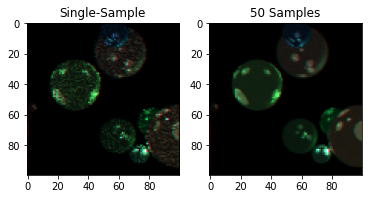

In [28]:
# Now, we can render a random example from this training set, side by sise.
i = random.randint(0,999)

x = x_set[i][:,:,:3]
y = y_set[i]

figure, subplot = plt.subplots(1,2)
subplot[0].imshow(x.squeeze())
subplot[0].title.set_text('Single-Sample'.format(i))
subplot[1].imshow(y.squeeze())
subplot[1].title.set_text('50 Samples'.format(i))

## To Be Continued
To explore this project further, look at the "train-modular" jupyter notebook. That notebook covers the creation of denoising networks, as well as the final, optimal, trained CNN.